In [100]:
from rich import print
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pdr
from astropy.visualization import ZScaleInterval
from matplotlib.patches import Rectangle, Circle


In [2]:
from pyarrow import parquet as pq
from tqdm import tqdm
import pandas as pd

In [3]:
from glcat_photometry_utils import mcmc_aperture_curve, plot_mcmc_results, get_percentile_ranges, plot_mcmc_walkers

In [4]:
np.random.seed(555)

In [5]:
metadata = pq.read_table('/Users/cm/github/gPhoton2/gPhoton/aspect/metadata.parquet').to_pandas()

In [6]:
ncat = pq.read_table('e23456_ncat.parquet')

In [87]:
ffull = pdr.read('/Users/cm/github/gPhoton2/test_data/e23456/e23456-nd-ffull-b00-image-g.fits.gz')

In [131]:
source_ix=3909
aperture_radii = np.array([1.5, 2.3, 3.8, 6.0, 9.0])#, 12.8, 17.3])
flux = np.array([ncat.column(f'NUV_CPS_APER{a}')[source_ix].as_py() for a, r in enumerate(aperture_radii)])
flux_err = np.array([ncat.column(f'NUV_CPS_ERR_APER{a}')[source_ix].as_py() for a,r in enumerate(aperture_radii)])
ix = np.where(np.isfinite(flux))

flat_samples,samples = mcmc_aperture_curve(aperture_radii,flux,flux_err,
                        nsteps = 1000, # number of MCMC steps
                        burnin = 200, # number of burn-in steps
                        nwalkers = 32, # number of mc walkers
                       )

# from plot_mcmc_results
from glcat_photometry_utils import gaussian_flux_model

percentiles=[16,50,84]
labels = ["cps", "sigma", "bg_cps"]
r = np.arange(1.5,17.3,0.1)

model_samples = np.zeros((len(flat_samples), len(r)))
for i, theta in enumerate(flat_samples):
    model_samples[i] = gaussian_flux_model(theta, r)

# Calculate the median and confidence intervals of the model predictions
model_percentiles = np.percentile(model_samples, [16, 50, 84], axis=0)

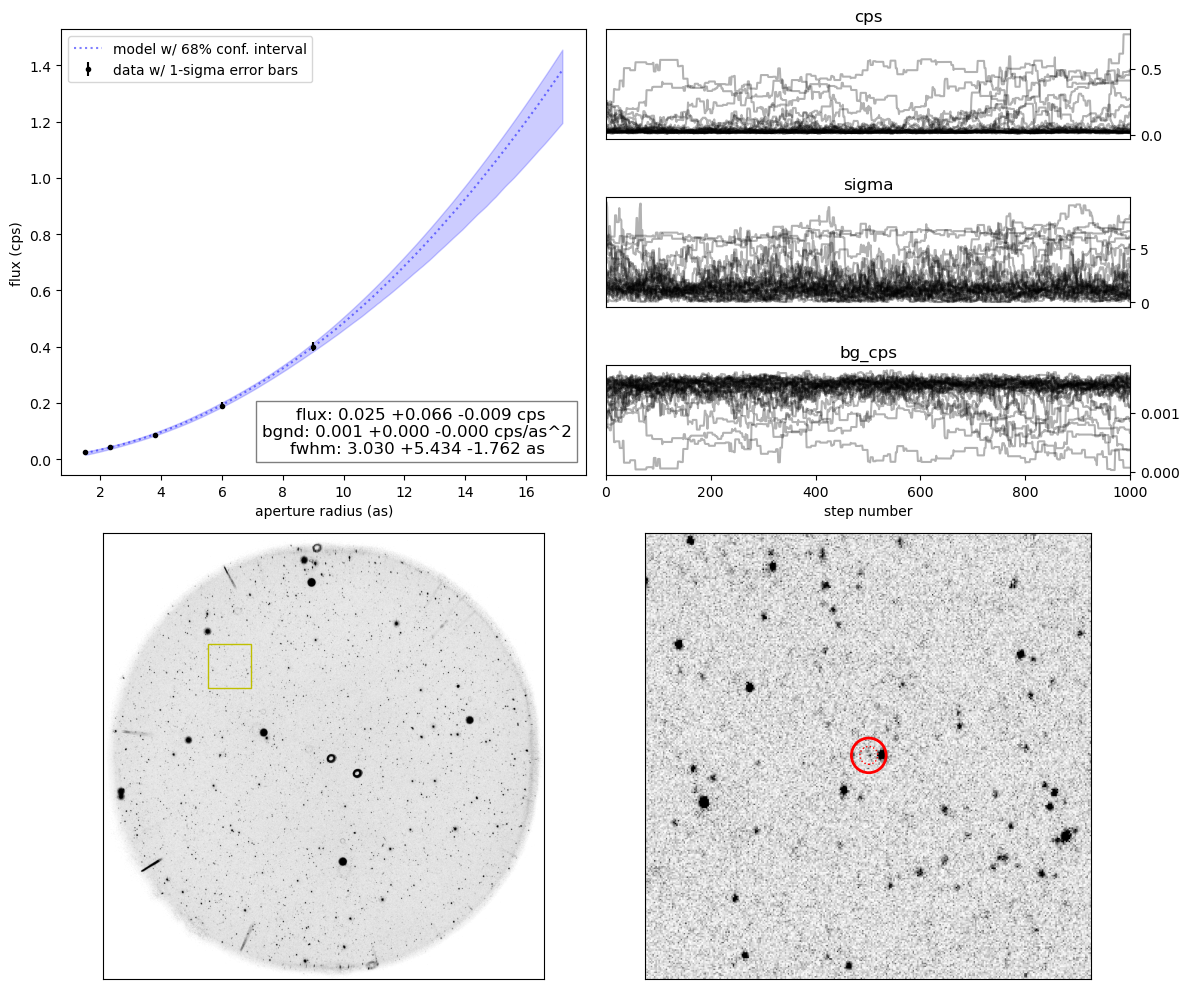

In [134]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12,10))
gs = GridSpec(6,6)

# model plot
mdl = fig.add_subplot(gs[:3,:3])
mdl.errorbar(aperture_radii, flux, yerr=flux_err, fmt='k.', label='data w/ 1-sigma error bars')
mdl.plot(r, model_percentiles[1], 'b:', label='model w/ 68% conf. interval',alpha=0.5)
mdl.fill_between(r, model_percentiles[0], model_percentiles[2], color='b', alpha=0.2)#, label='68% confidence interval')
stats = get_percentile_ranges(flat_samples, percentiles, labels)
# textstr = '\n'.join([f"{label}: {stats[label][0]:.3f} +{stats[label][2]:.3f} -{stats[label][1]:.3f}" for label in ['cps','bg_cps','sigma']])
textstr = '\n'.join([f"{'flux'}: {stats['cps'][0]:.3f} +{stats['cps'][2]:.3f} -{stats['cps'][1]:.3f} cps     ",
                     f"{'bgnd'}: {stats['bg_cps'][0]:.3f} +{stats['bg_cps'][2]:.3f} -{stats['bg_cps'][1]:.3f} cps/as^2",
                     f"{'fwhm'}: {2.355*stats['sigma'][0]:.3f} +{2.355*stats['sigma'][2]:.3f} -{2.355*stats['sigma'][1]:.3f} as     "])

mdl.text(17.5, 0.01, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5), ha='right', va='bottom')

mdl.set_xlabel('aperture radius (as)')
mdl.set_ylabel('flux (cps)')
mdl.legend()

# walkers plot
ndim = 3
labels = ["cps", "sigma", "bg_cps"]
for j in range(ndim):
    wkr = fig.add_subplot(gs[j,3:])
    wkr.plot(samples[:, :, j], "k", alpha=0.3)
    wkr.set_xlim(0, len(samples))
    wkr.set_title(labels[j])
    wkr.yaxis.set_label_coords(-0.1, 0.5)
    wkr.yaxis.tick_right()
    if j<2:
        wkr.set_xticks([])
wkr.set_xlabel("step number");

imgx = float(ncat.column('NUV_XCENTER')[source_ix].as_py())
imgy = float(ncat.column('NUV_YCENTER')[source_ix].as_py())
imsz = np.shape(ffull['CNT'])
boxsz = 150
x1, x2, y1, y2 = (max(int(imgy - boxsz), 0),
                  min(int(imgy + boxsz), imsz[0]),
                  max(int(imgx - boxsz), 0),
                  min(int(imgx + boxsz), imsz[1]))
x1_,y1_=0,0

# full frame image
ffi = fig.add_subplot(gs[3:,:3])
ffi.imshow(ZScaleInterval()(ffull['CNT']/expt[0]),origin='lower',cmap='Greys')
rect = Rectangle((y1 - y1_, x1 - x1_), 2 * boxsz, 2 * boxsz,
                 linewidth=1, edgecolor='y', facecolor='none',ls='solid')
ffi.add_patch(rect)
ffi.set_xticks([])
ffi.set_yticks([])

# sub frame image
sfi = fig.add_subplot(gs[3:,3:])
plt.imshow(ZScaleInterval()(ffull['CNT'][x1:x2,y1:y2]/expt[0]),origin='lower',cmap='Greys')
circ1 = Circle((boxsz, boxsz), 17.5/1.5,
              linewidth=2, edgecolor='r', facecolor='none', ls='solid')
sfi.add_patch(circ1)
circ2 = Circle((boxsz, boxsz), 9.0/1.5,
              linewidth=1, edgecolor='r', facecolor='none', ls='dotted')
sfi.add_patch(circ2)


sfi.set_xticks([])
sfi.set_yticks([])

plt.tight_layout()